In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from tqdm import tqdm

from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
import optuna

In [148]:
df_pli = pd.read_csv('pli.csv')
df_pli.head()

,order,birth,death,participant,trial,band,bars,mean_bar,std_bar,max_bar,min_bar,mean_birth,std_birth,mean_death,std_death
0,1,0.452494,0.522026,s28,0,0,0.069532,0.035584,0.07296,0.402448,0.000019,0.207233,0.230367,0.242817,0.257757
1,1,0.569148,0.628024,s28,0,0,0.058876,0.035584,0.07296,0.402448,0.000019,0.207233,0.230367,0.242817,0.257757
2,1,0.603009,0.615954,s28,0,0,0.012945,0.035584,0.07296,0.402448,0.000019,0.207233,0.230367,0.242817,0.257757
3,1,0.550330,0.558924,s28,0,0,0.008595,0.035584,0.07296,0.402448,0.000019,0.207233,0.230367,0.242817,0.257757
4,1,0.151801,0.159305,s28,0,0,0.007504,0.035584,0.07296,0.402448,0.000019,0.207233,0.230367,0.242817,0.257757


In [149]:
df_pli.describe()

,order,birth,death,trial,band,bars,mean_bar,std_bar,max_bar,min_bar,mean_birth,std_birth,mean_death,std_death
count,194034.000000,194034.000000,194034.000000,194034.000000,194034.000000,1.940340e+05,194034.000000,194034.000000,194034.000000,1.940340e+05,194034.000000,194034.000000,194034.000000,194034.000000
mean,0.181999,0.059232,0.212326,19.526403,1.505746,1.530932e-01,0.153093,0.160937,0.867384,1.680582e-02,0.059232,0.023122,0.212326,0.176800
std,0.385845,0.145156,0.212306,11.537352,1.100923,1.876553e-01,0.082928,0.049620,0.282892,2.347279e-02,0.133422,0.052423,0.114373,0.027859
min,0.000000,0.000000,0.000058,0.000000,0.000000,5.435623e-08,0.000231,0.000347,0.001965,5.435623e-08,0.000000,0.000000,0.003299,0.003163
25%,0.000000,0.000000,0.052926,10.000000,1.000000,2.969286e-02,0.080685,0.162056,1.000000,5.542559e-04,0.000000,0.000000,0.127457,0.171121
50%,0.000000,0.000000,0.145031,20.000000,2.000000,9.221407e-02,0.144695,0.177375,1.000000,6.906941e-03,0.000000,0.000000,0.187354,0.179028
75%,0.000000,0.000000,0.309468,30.000000,2.000000,2.108436e-01,0.213900,0.188705,1.000000,2.152747e-02,0.000000,0.000000,0.269355,0.190766
max,1.000000,0.714788,1.000000,39.000000,3.000000,1.000000e+00,0.392728,0.231462,1.000000,1.208029e-01,0.511116,0.262331,0.563425,0.277704


<Axes: >

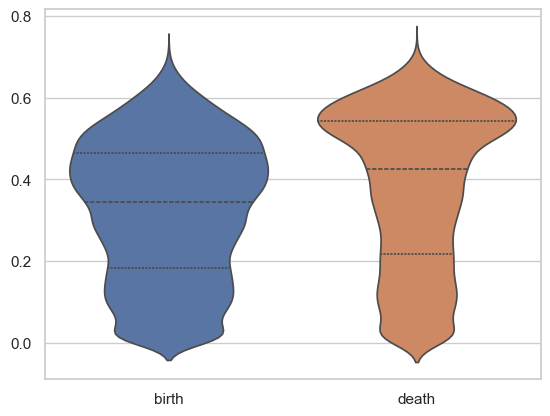

In [111]:
# violin plot
sns.violinplot(data=df_pli.loc[df_pli['order'] == 1, ['birth', 'death']], inner='quart')

In [180]:
# label extraction

participants = df_pli['participant'].unique()
participants = np.sort(participants)
participants

array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32'], dtype=object)

In [151]:
data_path = 'data/deap_filtered'
n_trials = 40 # DEAP-specific
for path in tqdm(participants):
    labels_for_participant = pickle.load(open(os.path.join(data_path, f"{path}.dat"), "rb"), encoding="latin1")["labels"]
    for trial in range(n_trials):
        df_pli.loc[(df_pli['participant'] == path) & (df_pli['trial'] == trial), 'valence'] = labels_for_participant[trial][0]
        df_pli.loc[(df_pli['participant'] == path) & (df_pli['trial'] == trial), 'arousal'] = labels_for_participant[trial][1]
        df_pli.loc[(df_pli['participant'] == path) & (df_pli['trial'] == trial), 'dominance'] = labels_for_participant[trial][2]
        df_pli.loc[(df_pli['participant'] == path) & (df_pli['trial'] == trial), 'liking'] = labels_for_participant[trial][3]

100%|██████████| 32/32 [01:19<00:00,  2.49s/it]


In [114]:
# one hot encoding for bands
df_pli = pd.concat([df_pli, pd.get_dummies(df_pli['band'], prefix='band')], axis=1)
df_pli.head()

,order,birth,death,participant,trial,band,bars,mean_bar,std_bar,max_bar,...,mean_death,std_death,valence,arousal,dominance,liking,band_0,band_1,band_2,band_3
0,1,0.452494,0.522026,s28,0,0,0.069532,0.035584,0.07296,0.402448,...,0.242817,0.257757,7.03,7.09,8.01,8.01,True,False,False,False
1,1,0.569148,0.628024,s28,0,0,0.058876,0.035584,0.07296,0.402448,...,0.242817,0.257757,7.03,7.09,8.01,8.01,True,False,False,False
2,1,0.603009,0.615954,s28,0,0,0.012945,0.035584,0.07296,0.402448,...,0.242817,0.257757,7.03,7.09,8.01,8.01,True,False,False,False
3,1,0.550330,0.558924,s28,0,0,0.008595,0.035584,0.07296,0.402448,...,0.242817,0.257757,7.03,7.09,8.01,8.01,True,False,False,False
4,1,0.151801,0.159305,s28,0,0,0.007504,0.035584,0.07296,0.402448,...,0.242817,0.257757,7.03,7.09,8.01,8.01,True,False,False,False


In [152]:
# train_test_split
from sklearn.model_selection import train_test_split

X = df_pli.drop(columns=['participant', 'trial', 'valence', 'arousal', 'dominance', 'liking'])
y = df_pli['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
X_train.count()

order         155227
birth         155227
death         155227
band          155227
bars          155227
mean_bar      155227
std_bar       155227
max_bar       155227
min_bar       155227
mean_birth    155227
std_birth     155227
mean_death    155227
std_death     155227
band_0        155227
band_1        155227
band_2        155227
band_3        155227
dtype: int64

In [117]:
y_train.head()

157417    1.00
34197     7.15
20280     9.00
116599    5.04
121617    8.78
Name: valence, dtype: float64

Baseline model:

In [14]:
%%time

svr = SVR(kernel="linear")
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mean_squared_error(y_test, y_pred)

CPU times: user 28min 27s, sys: 32.7 s, total: 29min
Wall time: 29min 45s


4.50411345684183

In [15]:
# saving the model
pickle.dump(svr, open('svr_valence.pkl', 'wb'))

In [36]:
y_train

157417    1.00
34197     7.15
20280     9.00
116599    5.04
121617    8.78
          ... 
119879    3.38
103694    6.15
131932    1.00
146867    7.96
121958    8.41
Name: valence, Length: 155227, dtype: float64

For the DEAP dataset, participants were categorized as having a positive emotion if they had a valence score of greater than or equal to 7 and an arousal score of greater than or equal to 7 in 40 trials per participant. Conversely, those participants whose valence scores are less than or equal to 3 and arousal scores are greater than or equal to 7 are categorized as having a negative emotion.  

In [153]:
%%time

# filter out entries where valence <= 3 or valence >= 7]
indices = (y_train <= 3) | (y_train >= 7)
X_train_filtered = X_train[indices]
y_train_filtered = y_train[indices]
X_test_filtered = X_test[(y_test <= 3) | (y_test >= 7)]
y_test_filtered = y_test[(y_test <= 3) | (y_test >= 7)]

CPU times: user 12.5 ms, sys: 5.6 ms, total: 18.1 ms
Wall time: 16.8 ms


In [154]:
y_train_filtered[y_train_filtered <= 3] = -1
y_train_filtered[y_train_filtered >= 7] = 1
y_test_filtered[y_test_filtered <= 3] = -1
y_test_filtered[y_test_filtered >= 7] = 1

In [67]:
%%time

svc = SVC(kernel="linear")
svc.fit(X_train_filtered, y_train_filtered)
y_pred_clf = svc.predict(X_test_filtered)

CPU times: user 5min 36s, sys: 7.68 s, total: 5min 43s
Wall time: 5min 55s


In [68]:
svc.score(X_test_filtered, y_test_filtered)

0.631714126186488

Changing the kernel to rbf

In [13]:
svc_rbf = SVC(kernel="rbf")
svc_rbf.fit(X_train_filtered, y_train_filtered)
y_pred_clf_rbf = svc_rbf.predict(X_test_filtered)

print(f"Accuracy: {accuracy_score(y_test_filtered, y_pred_clf_rbf)}")
print(f"Precision: {precision_score(y_test_filtered, y_pred_clf_rbf, average='weighted')}")
print(f"Recall: {recall_score(y_test_filtered, y_pred_clf_rbf, average='weighted')}")
print(f"F1: {f1_score(y_test_filtered, y_pred_clf_rbf, average='weighted')}")

Accuracy: 0.631714126186488
Precision: 0.39906273722355806
Recall: 0.631714126186488
F1: 0.4891331524551003


/Users/h1de0us/.pyenv/versions/3.10.13/envs/coursework/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
svc_rbf.score(X_test_filtered, y_test_filtered)

0.631714126186488

In [15]:
svc_rbf = SVC(kernel="rbf", C=10)
svc_rbf.fit(X_train_filtered, y_train_filtered)
y_pred_clf_rbf = svc_rbf.predict(X_test_filtered)

print(f"Accuracy: {accuracy_score(y_test_filtered, y_pred_clf_rbf)}")
print(f"Precision: {precision_score(y_test_filtered, y_pred_clf_rbf, average='weighted')}")
print(f"Recall: {recall_score(y_test_filtered, y_pred_clf_rbf, average='weighted')}")
print(f"F1: {f1_score(y_test_filtered, y_pred_clf_rbf, average='weighted')}")

Accuracy: 0.631714126186488
Precision: 0.39906273722355806
Recall: 0.631714126186488
F1: 0.4891331524551003


/Users/h1de0us/.pyenv/versions/3.10.13/envs/coursework/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# using optuna for hyperparameter optimization

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)
    svc_rbf = SVC(kernel="rbf", C=C, gamma=gamma)
    svc_rbf.fit(X_train_filtered, y_train_filtered)
    y_pred_clf_rbf = svc_rbf.predict(X_test_filtered)
    acc = accuracy_score(y_test_filtered, y_pred_clf_rbf)
    print(f"Accuracy: {acc} for C={C}, gamma={gamma}")
    return acc

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
study.best_params

[I 2024-05-17 17:39:19,730] A new study created in memory with name: no-name-d33a5396-0d3b-496c-8a58-8e175c9766af
/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-10, 1e10)
/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)
[I 2024-05-17 17:46:42,350] Trial 0 finished with value: 0.631714126186488 and parameters: {'C': 0.0005853009387524039, 'gamma': 34877.79966283774}. Best is trial 0 with value: 0.631714126186488.


Accuracy: 0.631714126186488 for C=0.0005853009387524039, gamma=34877.79966283774


/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-10, 1e10)
/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)
[I 2024-05-17 17:58:06,524] Trial 1 finished with value: 0.6317699609156896 and parameters: {'C': 0.06360406018291699, 'gamma': 248014950.21583796}. Best is trial 1 with value: 0.6317699609156896.


Accuracy: 0.6317699609156896 for C=0.06360406018291699, gamma=248014950.21583796


/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-10, 1e10)
/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)
[I 2024-05-17 18:07:57,200] Trial 2 finished with value: 0.631714126186488 and parameters: {'C': 0.5069834315782384, 'gamma': 0.26297336135679433}. Best is trial 1 with value: 0.6317699609156896.


Accuracy: 0.631714126186488 for C=0.5069834315782384, gamma=0.26297336135679433


/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-10, 1e10)
/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)
[I 2024-05-17 18:12:59,147] Trial 3 finished with value: 0.631714126186488 and parameters: {'C': 7.112642883668108e-10, 'gamma': 34887.36787286055}. Best is trial 1 with value: 0.6317699609156896.


Accuracy: 0.631714126186488 for C=7.112642883668108e-10, gamma=34887.36787286055


/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-10, 1e10)
/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_34771/2671007460.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)


In [11]:
# TBD: groupby и всякие статистики
grouped_data = df_pli.groupby(['participant', 'band']).mean()
grouped_data

order     birth     death      trial      bars  mean_bar  \
participant band                                                                
s01         0     0.337253  0.123080  0.311249  19.551042  0.188169  0.188169   
            1     0.364428  0.119295  0.293207  19.741671  0.173912  0.173912   
            2     0.352480  0.141183  0.360135  19.480418  0.218952  0.218952   
            3     0.336544  0.172013  0.450175  19.418406  0.278162  0.278162   
s02         0     0.086220  0.007804  0.083050  19.521739  0.075246  0.075246   
...                    ...       ...       ...        ...       ...       ...   
s31         3     0.215686  0.103346  0.342007  19.495256  0.238661  0.238661   
s32         0     0.122435  0.029977  0.143080  19.411890  0.113104  0.113104   
            1     0.244363  0.073967  0.233388  19.624010  0.159421  0.159421   
            2     0.278650  0.104057  0.297848  19.623037  0.193791  0.193791   
            3     0.127375  0.049820  0.234498  19.542576  0.184678  0.184678   

                   std_bar   max_bar   min_bar  mean_birth  std_birth  \
participant band                                                        
s01         0     0.129678  0.757285  0.039443    0.123080   0.030662   
            1     0.123897  0.746158  0.034861    0.119295   0.027992   
            2     0.121681  0.729892  0.061285    0.141183   0.023436   
            3     0.114598  0.751616  0.080159    0.172013   0.028793   
s02         0     0.182671  0.933543  0.000499    0.007804   0.015611   
...                    ...       ...       ...         ...        ...   
s31         3     0.154584  0.833057  0.022631    0.103346   0.026259   
s32         0     0.183290  0.928475  0.002388    0.029977   0.020970   
            1     0.151574  0.848309  0.011619    0.073967   0.023861   
            2     0.146495  0.819756  0.016445    0.104057   0.029923   
            3     0.192664  0.920427  0.007483    0.049820   0.021852   

                  mean_death  std_death  
participant band                         
s01         0       0.311249   0.146825  
            1       0.293207   0.137073  
            2       0.360135   0.131001  
            3       0.450175   0.126709  
s02         0       0.083050   0.197504  
...                      ...        ...  
s31         3       0.342007   0.171528  
s32         0       0.143080   0.196442  
            1       0.233388   0.159768  
            2       0.297848   0.163859  
            3       0.234498   0.204346  

[128 rows x 13 columns]

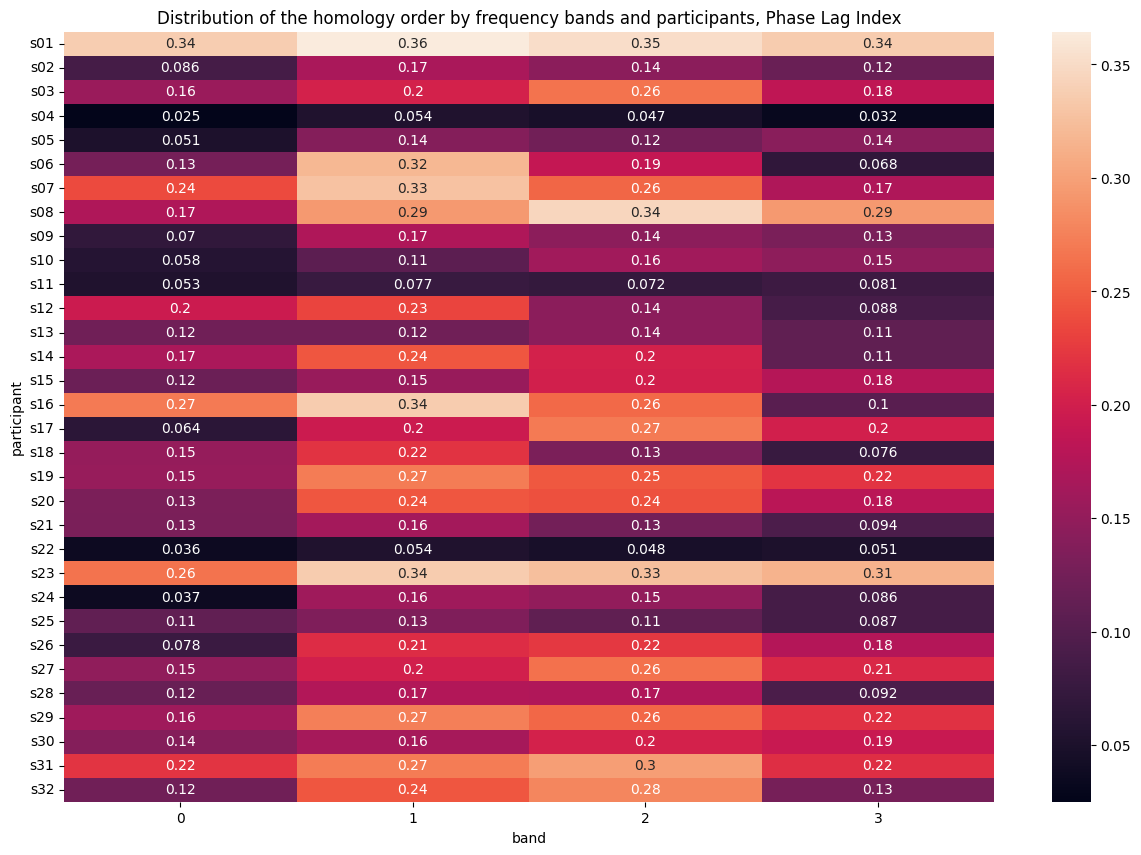

In [27]:
# plot a heatmap where X is participant, Y is trial and hue is order
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(grouped_data.reset_index().pivot(index='participant', columns='band', values='order'), ax=ax, annot=True)
ax.set_title("Distribution of the homology order by frequency bands and participants, Phase Lag Index")
plt.show()

In [101]:
df_plv = pd.read_csv('plv.csv')
df_plv.head()

,order,birth,death,participant,trial,band,bars,mean_bar,std_bar,max_bar,min_bar,mean_birth,std_birth,mean_death,std_death
0,1,0.586639,0.667508,s28,0,0,0.080869,0.039335,0.079472,0.407148,0.000052,0.192672,0.225038,0.232007,0.257734
1,1,0.458094,0.536450,s28,0,0,0.078357,0.039335,0.079472,0.407148,0.000052,0.192672,0.225038,0.232007,0.257734
2,1,0.592009,0.616404,s28,0,0,0.024395,0.039335,0.079472,0.407148,0.000052,0.192672,0.225038,0.232007,0.257734
3,1,0.023978,0.027923,s28,0,0,0.003945,0.039335,0.079472,0.407148,0.000052,0.192672,0.225038,0.232007,0.257734
4,1,0.011423,0.013244,s28,0,0,0.001821,0.039335,0.079472,0.407148,0.000052,0.192672,0.225038,0.232007,0.257734


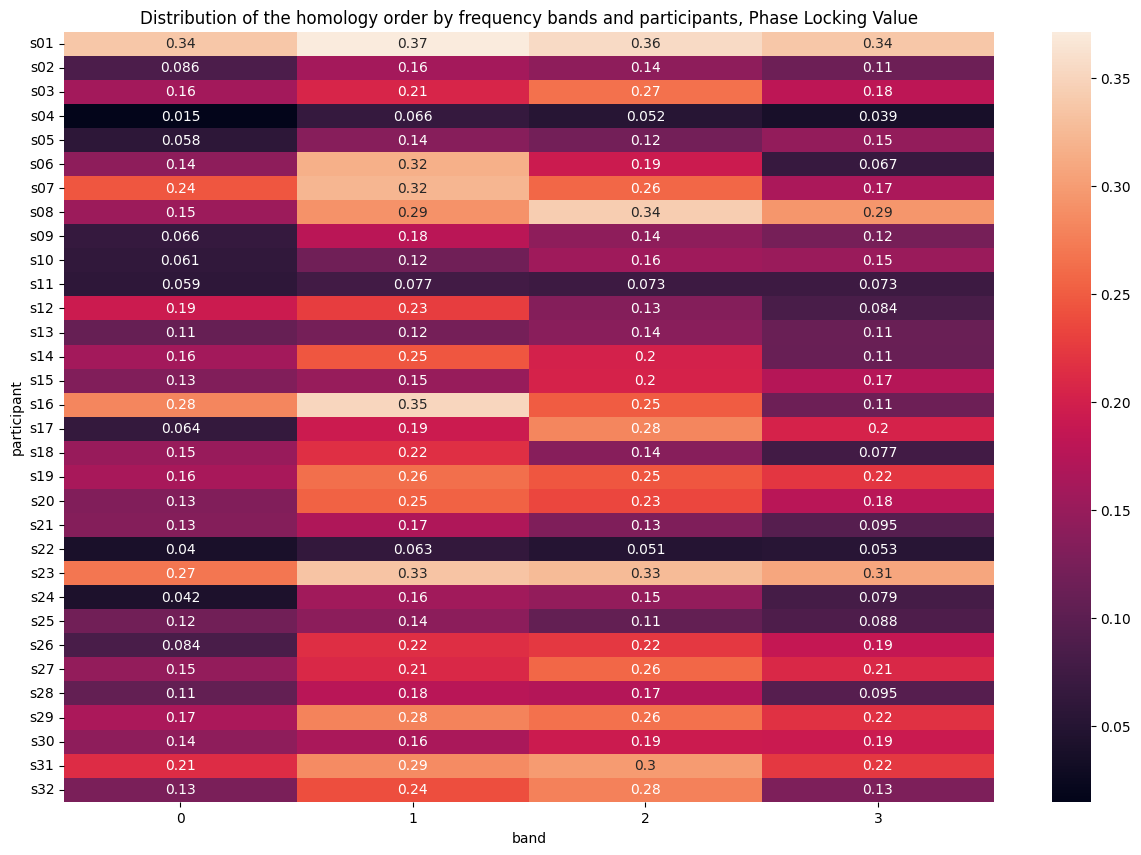

In [26]:
grouped_data_plv = df_plv.groupby(['participant', 'band']).mean()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(grouped_data_plv.reset_index().pivot(index='participant', columns='band', values='order'), ax=ax, annot=True)
ax.set_title("Distribution of the homology order by frequency bands and participants, Phase Locking Value")
plt.show()

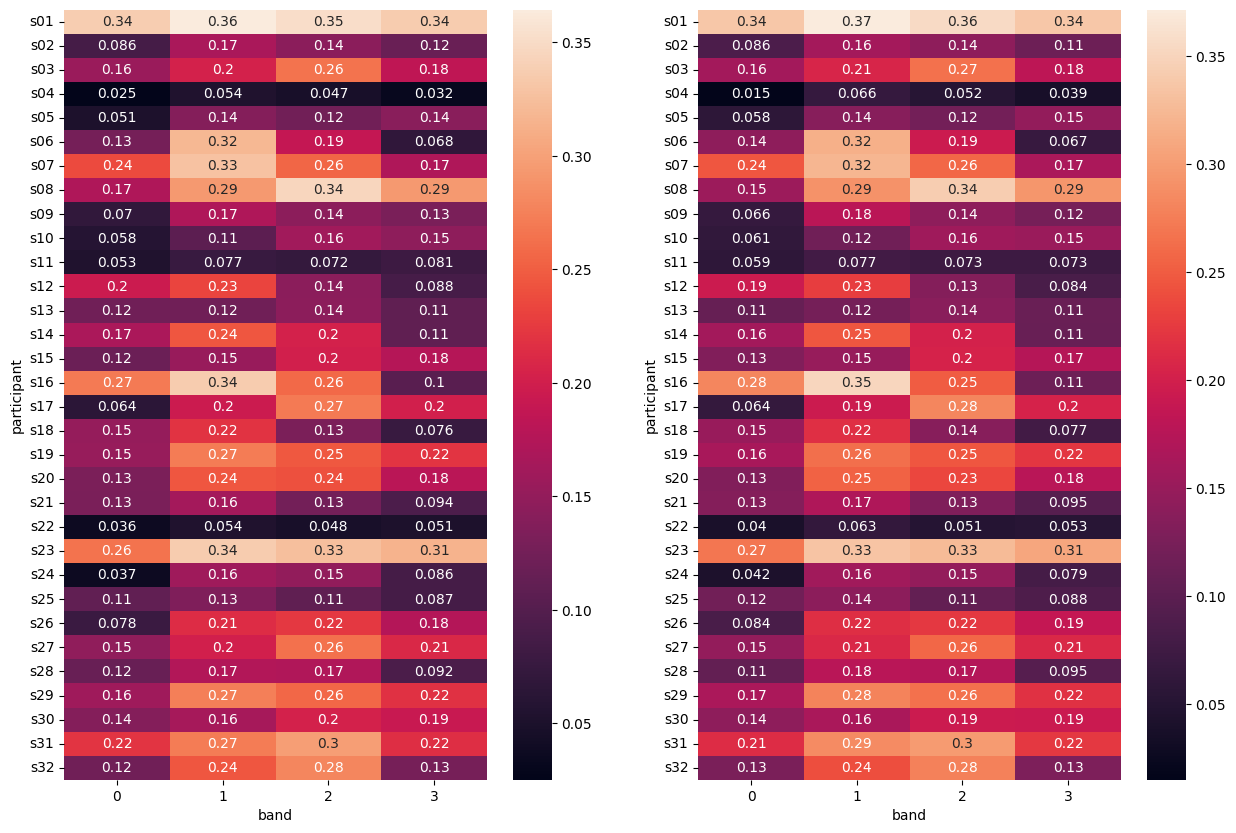

In [30]:
# plot them together
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
sns.heatmap(grouped_data.reset_index().pivot(index='participant', columns='band', values='order'), ax=axs[0], annot=True)
# axs[0].set_title("Distribution of the homology order by frequency bands and participants, Phase Lag Index (left) and Phase Locking Value (right)")
sns.heatmap(grouped_data_plv.reset_index().pivot(index='participant', columns='band', values='order'), ax=axs[1], annot=True)
plt.show()

### Plotting connectivity matrices as heatmaps

In [41]:
# plot pli connectivity matrices:
connectivity_matrix = np.load('data/deap_filtered/s01_pli_5.0_trial_0.npy')
connectivity_matrix = connectivity_matrix + np.rot90(connectivity_matrix, 2)

Text(0.5, 1.0, 'PLI connectivity matrix for band gamma')

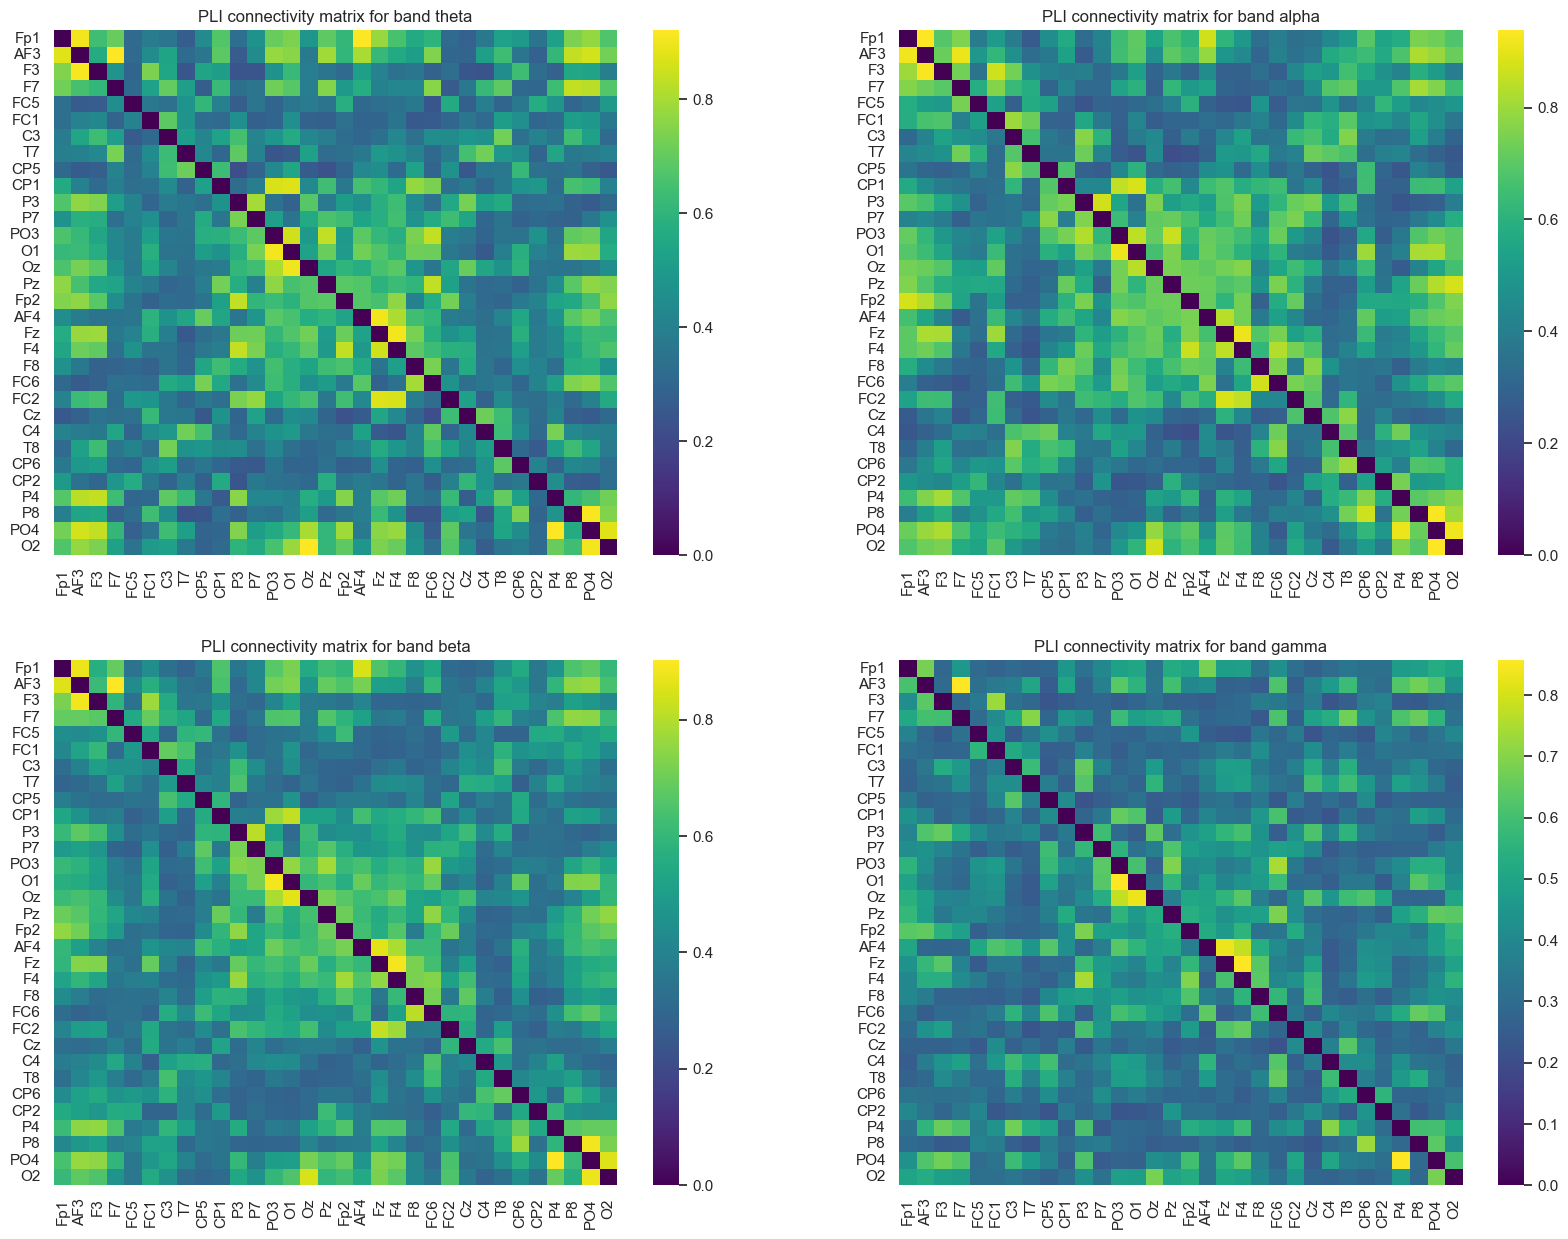

In [51]:
channels = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 
                         'FC1', 'C3', 'T7', 'CP5', 'CP1', 
                         'P3', 'P7', 'PO3', 'O1', 'Oz', 
                         'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 
                         'F8', 'FC6', 'FC2', 'Cz', 'C4', 
                         'T8', 'CP6', 'CP2', 'P4', 'P8', 
                         'PO4', 'O2']

sns.set(style="whitegrid")
cmap = sns.color_palette("viridis", as_cmap=True)
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i in range(connectivity_matrix.shape[-1]):
    sns.heatmap(connectivity_matrix[:, :, i], ax=axs[i // 2, i % 2], 
                cmap=cmap,
                xticklabels=channels,
                yticklabels=channels)

axs[0, 0].set_title("PLI connectivity matrix for band theta")
axs[0, 1].set_title("PLI connectivity matrix for band alpha")
axs[1, 0].set_title("PLI connectivity matrix for band beta")
axs[1, 1].set_title("PLI connectivity matrix for band gamma")

In [52]:
# the same for plv
connectivity_matrix = np.load('data/deap_filtered/s01_plv_3.0_trial_0.npy')
connectivity_matrix = connectivity_matrix + np.rot90(connectivity_matrix, 2)

Text(0.5, 1.0, 'PLI connectivity matrix for band gamma')

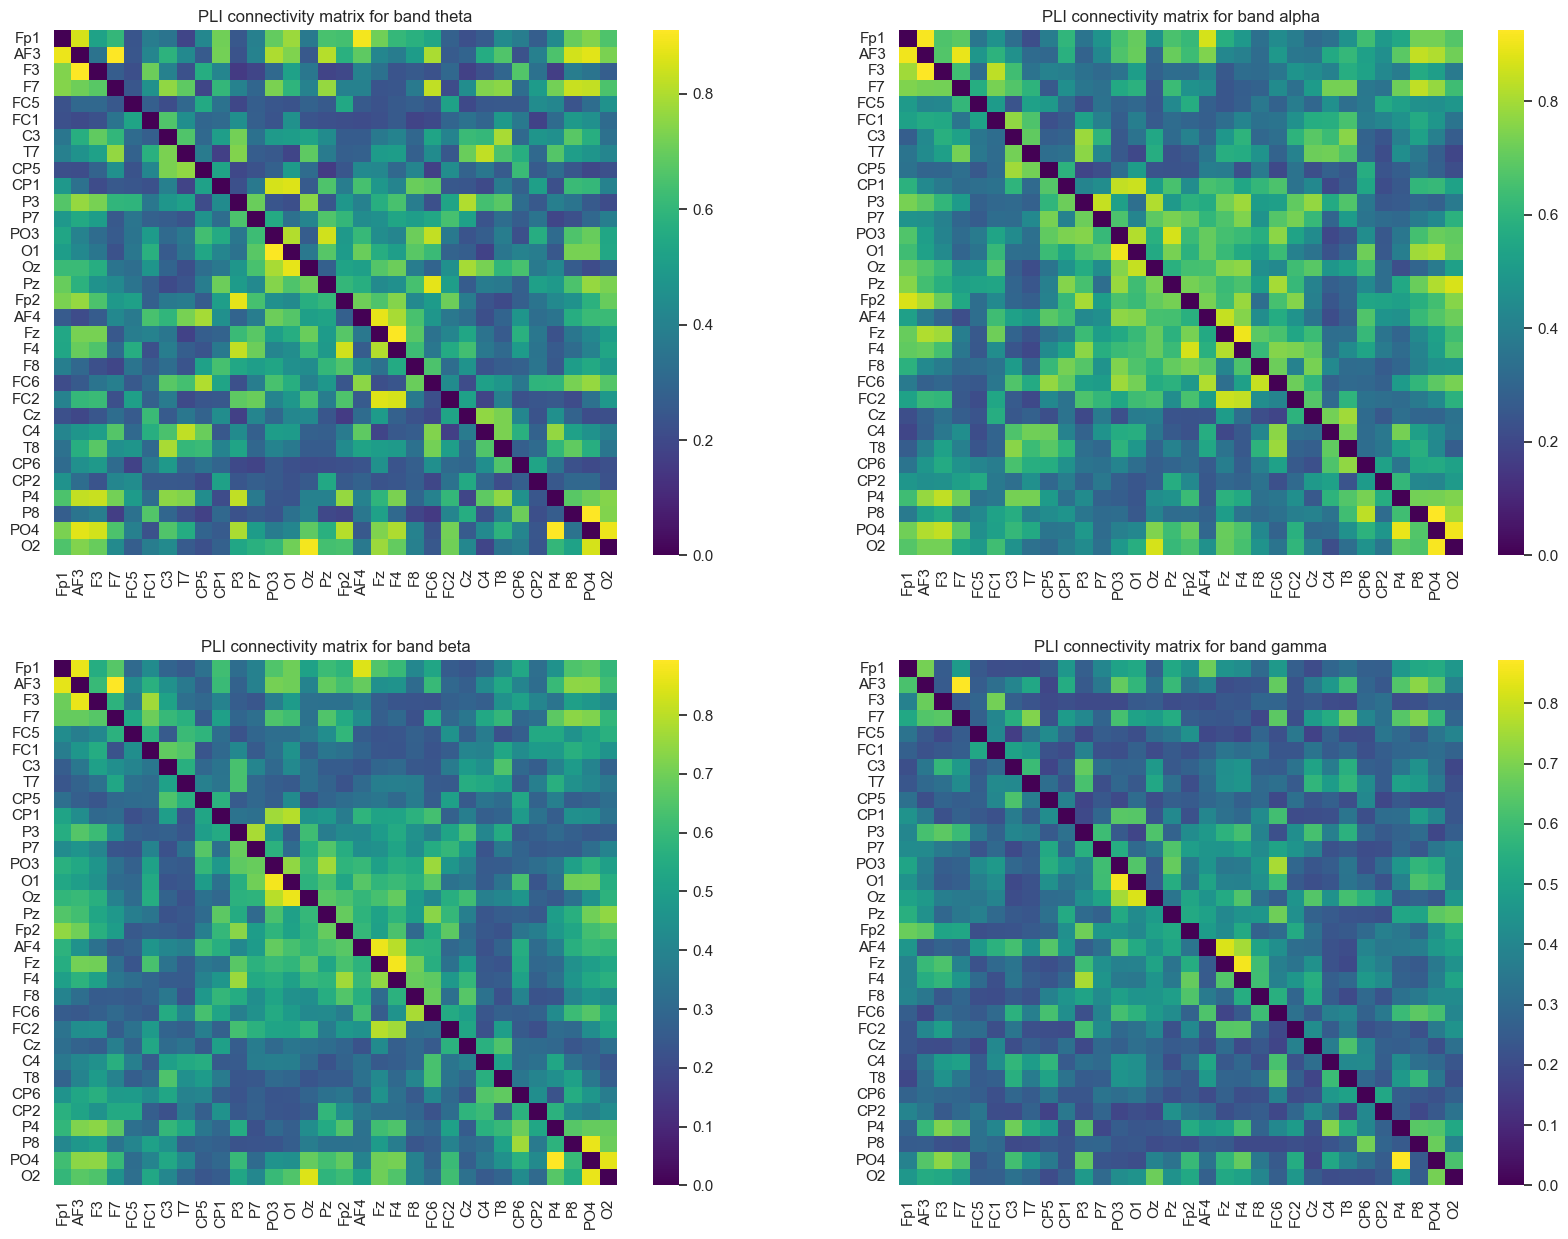

In [53]:
channels = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 
                         'FC1', 'C3', 'T7', 'CP5', 'CP1', 
                         'P3', 'P7', 'PO3', 'O1', 'Oz', 
                         'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 
                         'F8', 'FC6', 'FC2', 'Cz', 'C4', 
                         'T8', 'CP6', 'CP2', 'P4', 'P8', 
                         'PO4', 'O2']

sns.set(style="whitegrid")
cmap = sns.color_palette("viridis", as_cmap=True)
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i in range(connectivity_matrix.shape[-1]):
    sns.heatmap(connectivity_matrix[:, :, i], ax=axs[i // 2, i % 2], 
                cmap=cmap,
                xticklabels=channels,
                yticklabels=channels)

axs[0, 0].set_title("PLI connectivity matrix for band theta")
axs[0, 1].set_title("PLI connectivity matrix for band alpha")
axs[1, 0].set_title("PLI connectivity matrix for band beta")
axs[1, 1].set_title("PLI connectivity matrix for band gamma")

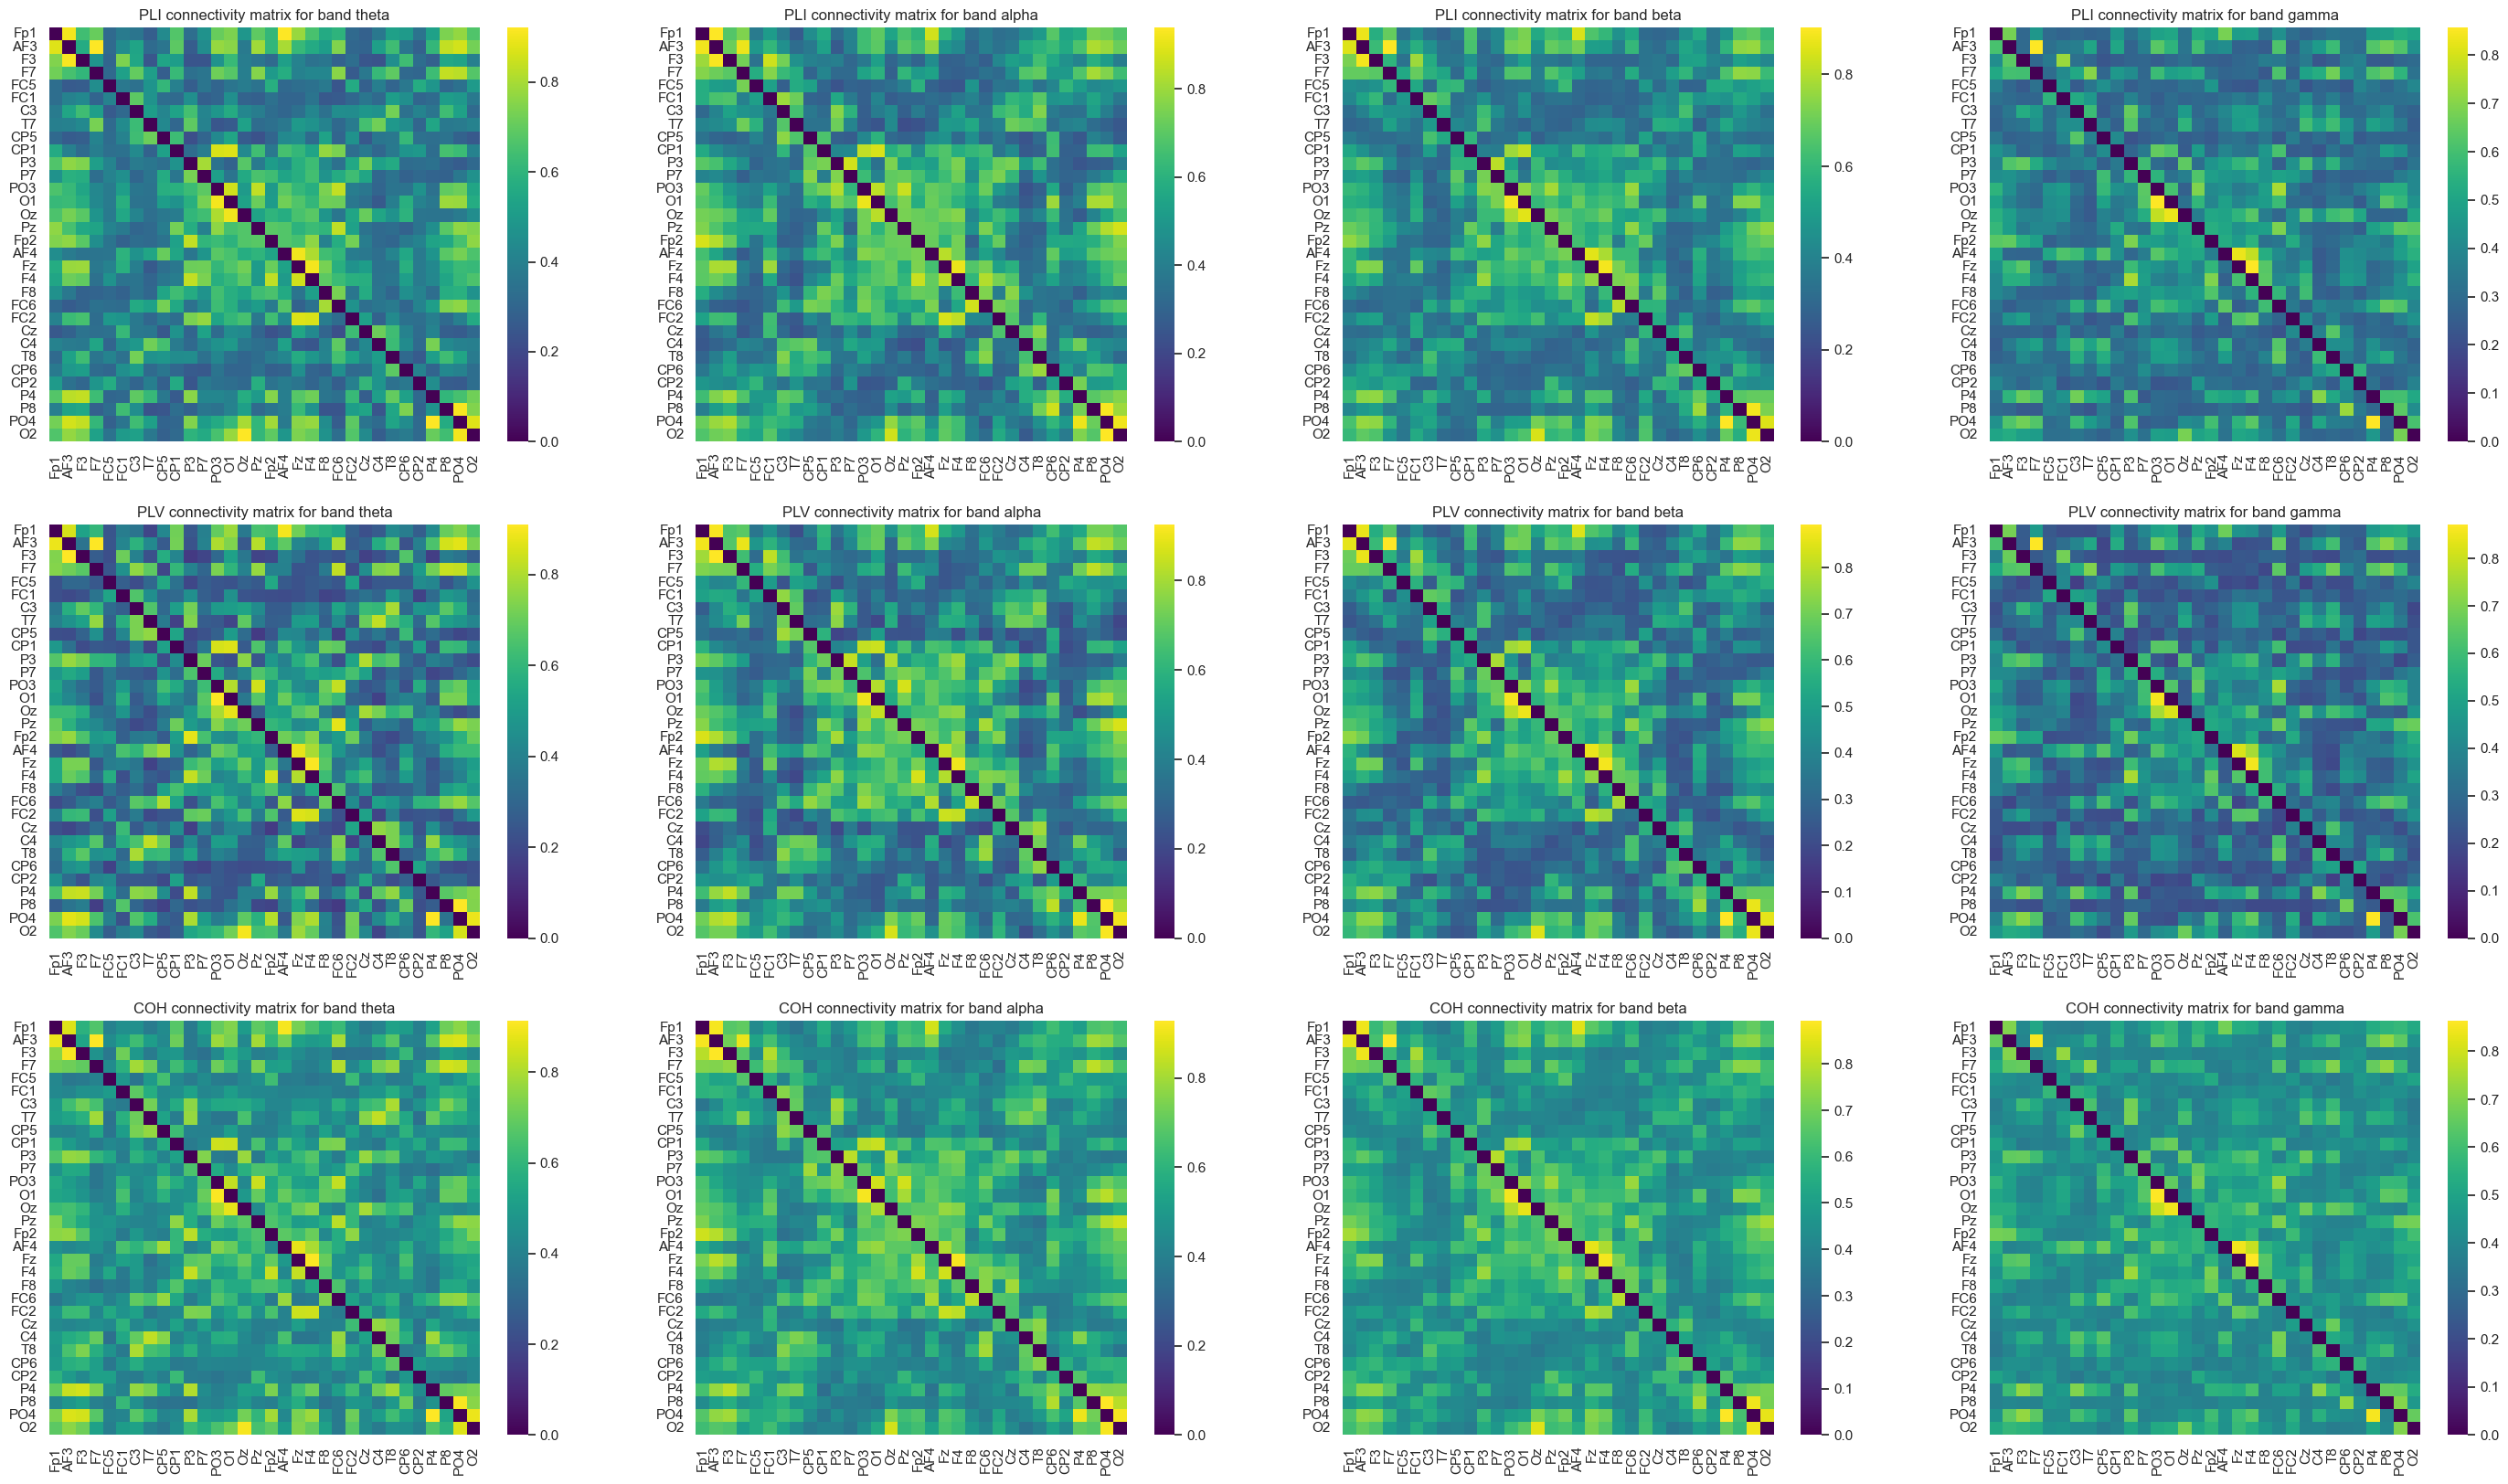

In [60]:
# plot all matrices on one graph
connectivity_matrix_pli = np.load('data/deap_filtered/s01_pli_5.0_trial_0.npy')
connectivity_matrix_pli = connectivity_matrix_pli + np.rot90(connectivity_matrix_pli, 2)

connectivity_matrix_plv = np.load('data/deap_filtered/s01_plv_3.0_trial_0.npy')
connectivity_matrix_plv = connectivity_matrix_plv + np.rot90(connectivity_matrix_plv, 2)

connectivity_matrix_coh = np.load('data/deap_filtered/s01_coh_10.0_trial_0.npy')
connectivity_matrix_coh = connectivity_matrix_coh + np.rot90(connectivity_matrix_coh, 2)

channels = ['Fp1', 'AF3', 'F3', 'F7', 'FC5',
            'FC1', 'C3', 'T7', 'CP5', 'CP1',
            'P3', 'P7', 'PO3', 'O1', 'Oz',
            'Pz', 'Fp2', 'AF4', 'Fz', 'F4',
            'F8', 'FC6', 'FC2', 'Cz', 'C4',
            'T8', 'CP6', 'CP2', 'P4', 'P8',
            'PO4', 'O2']
sns.set(style="whitegrid")
cmap = sns.color_palette("viridis", as_cmap=True)
fig, axs = plt.subplots(3, 4, figsize=(35, 20))
# first row for pli, second row for plv
for i in range(connectivity_matrix_pli.shape[-1]):
    sns.heatmap(connectivity_matrix_pli[:, :, i], ax=axs[0, i], 
                cmap=cmap,
                xticklabels=channels,
                yticklabels=channels)

axs[0, 0].set_title("PLI connectivity matrix for band theta")
axs[0, 1].set_title("PLI connectivity matrix for band alpha")
axs[0, 2].set_title("PLI connectivity matrix for band beta")
axs[0, 3].set_title("PLI connectivity matrix for band gamma")

for i in range(connectivity_matrix_plv.shape[-1]):
    sns.heatmap(connectivity_matrix_plv[:, :, i], ax=axs[1, i], 
                cmap=cmap,
                xticklabels=channels,
                yticklabels=channels)

axs[1, 0].set_title("PLV connectivity matrix for band theta")
axs[1, 1].set_title("PLV connectivity matrix for band alpha")
axs[1, 2].set_title("PLV connectivity matrix for band beta")
axs[1, 3].set_title("PLV connectivity matrix for band gamma")

for i in range(connectivity_matrix_coh.shape[-1]):
    sns.heatmap(connectivity_matrix_coh[:, :, i], ax=axs[2, i], 
                cmap=cmap,
                xticklabels=channels,
                yticklabels=channels)

axs[2, 0].set_title("COH connectivity matrix for band theta")
axs[2, 1].set_title("COH connectivity matrix for band alpha")
axs[2, 2].set_title("COH connectivity matrix for band beta")
axs[2, 3].set_title("COH connectivity matrix for band gamma")

plt.show()


### Some boxplots regarding the distributions

In [83]:
grouped_by_band_pli = df_pli.groupby('band')
grouped_by_band_pli['order'].describe()

,count,mean,std,min,25%,50%,75%,max
band,,,,,,,,
0,46210.0,0.141311,0.348346,0.0,0.0,0.0,0.0,1.0
1,50608.0,0.215934,0.411473,0.0,0.0,0.0,0.0,1.0
2,50090.0,0.207826,0.405756,0.0,0.0,0.0,0.0,1.0
3,47126.0,0.158002,0.364747,0.0,0.0,0.0,0.0,1.0


/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_56402/1456835828.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['theta', 'alpha', 'beta', 'gamma'])


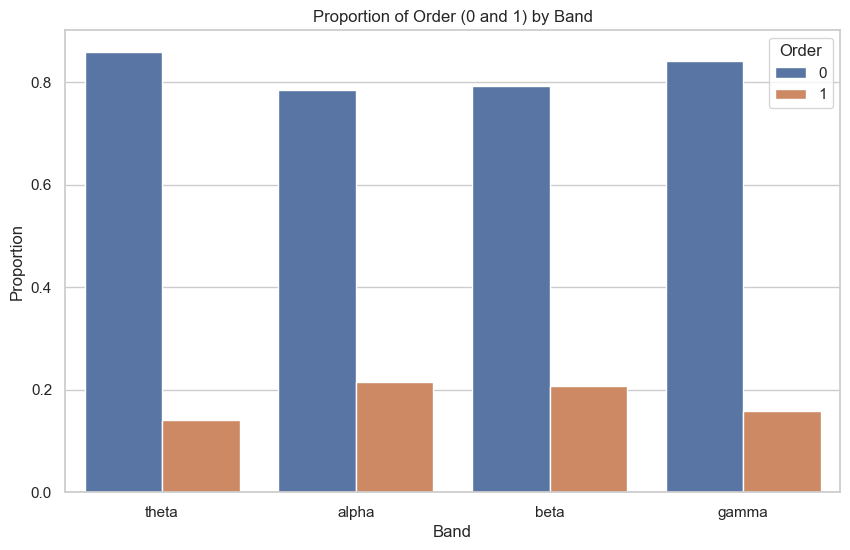

In [100]:
# Calculate the proportion of 'order' for each 'band'
proportion_df = df_pli.groupby(['band', 'order']).size().reset_index(name='count')
total_counts = df_pli.groupby('band')['order'].count().reset_index(name='total')
proportion_df = proportion_df.merge(total_counts, on='band')
proportion_df['proportion'] = proportion_df['count'] / proportion_df['total']

sns.set(style='whitegrid')

# Plot the bar plot using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='band', y='proportion', hue='order', data=proportion_df, ax=ax)

# Customize the plot (optional)
ax.set_title('Proportion of Order (0 and 1) by Band, Phase Lag Index')
ax.set_xlabel('Band')
ax.set_ylabel('Proportion')
ax.set_xticklabels(['theta', 'alpha', 'beta', 'gamma'])
ax.legend(title='Order', loc='upper right')

# Show the plot
plt.show()

In [103]:
df_plv = pd.read_csv('plv.csv')
df_coh = pd.read_csv('coh.csv')

/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_56402/1658228412.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['theta', 'alpha', 'beta', 'gamma'])
/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_56402/1658228412.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['theta', 'alpha', 'beta', 'gamma'])
/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_56402/1658228412.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(['theta', 'alpha', 'beta', 'gamma'])


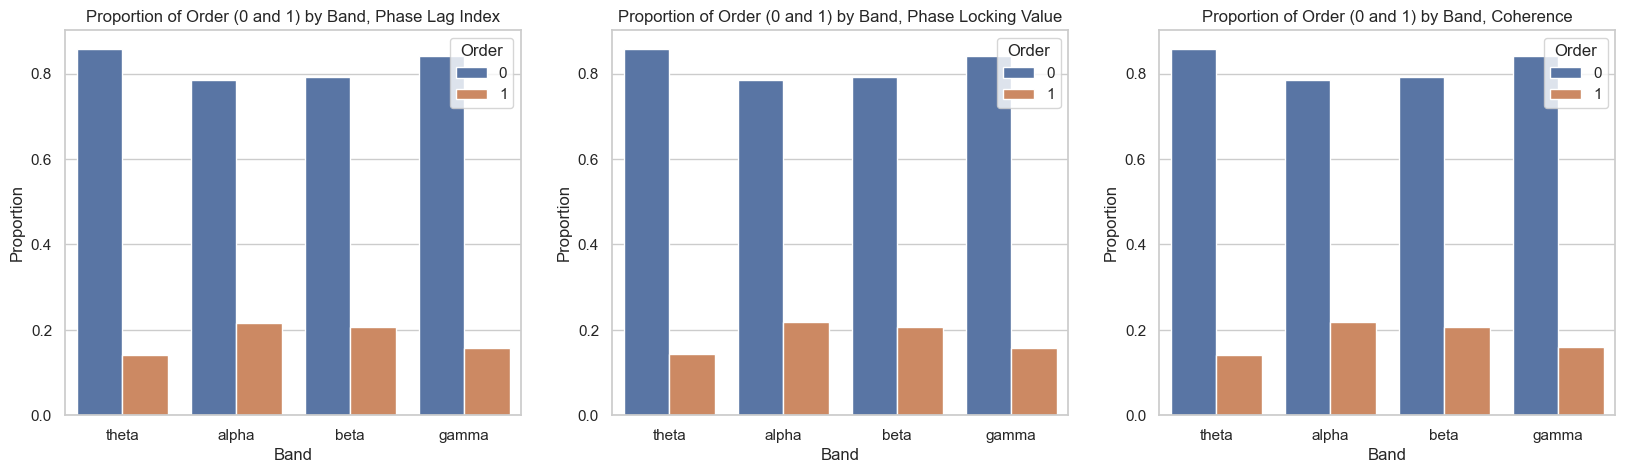

In [105]:
# the same for PLI, PLV, COH, one plot 

grouped_by_band_pli = df_pli.groupby('band')
proportion_df_pli = df_pli.groupby(['band', 'order']).size().reset_index(name='count')
total_counts_pli = df_pli.groupby('band')['order'].count().reset_index(name='total')
proportion_df_pli = proportion_df_pli.merge(total_counts, on='band')
proportion_df_pli['proportion'] = proportion_df_pli['count'] / proportion_df_pli['total']

grouped_by_band_plv = df_plv.groupby('band')
proportion_df_plv = df_plv.groupby(['band', 'order']).size().reset_index(name='count')
total_counts_plv = df_plv.groupby('band')['order'].count().reset_index(name='total')
proportion_df_plv = proportion_df_plv.merge(total_counts, on='band')
proportion_df_plv['proportion'] = proportion_df_plv['count'] / proportion_df_plv['total']

grouped_by_band_coh = df_coh.groupby('band')
proportion_df_coh = df_coh.groupby(['band', 'order']).size().reset_index(name='count')
total_counts_coh = df_coh.groupby('band')['order'].count().reset_index(name='total')
proportion_df_coh = proportion_df_coh.merge(total_counts, on='band')
proportion_df_coh['proportion'] = proportion_df_coh['count'] / proportion_df_coh['total']

sns.set(style='whitegrid')

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# barplots
sns.barplot(x='band', y='proportion', hue='order', data=proportion_df_pli, ax=axs[0])
sns.barplot(x='band', y='proportion', hue='order', data=proportion_df_plv, ax=axs[1])
sns.barplot(x='band', y='proportion', hue='order', data=proportion_df_coh, ax=axs[2])

axs[0].set_title('Proportion of Order (0 and 1) by Band, Phase Lag Index')
axs[0].set_xlabel('Band')
axs[0].set_ylabel('Proportion')
axs[0].set_xticklabels(['theta', 'alpha', 'beta', 'gamma'])
axs[0].legend(title='Order', loc='upper right')

axs[1].set_title('Proportion of Order (0 and 1) by Band, Phase Locking Value')
axs[1].set_xlabel('Band')
axs[1].set_ylabel('Proportion')
axs[1].set_xticklabels(['theta', 'alpha', 'beta', 'gamma'])
axs[1].legend(title='Order', loc='upper right')

axs[2].set_title('Proportion of Order (0 and 1) by Band, Coherence')
axs[2].set_xlabel('Band')
axs[2].set_ylabel('Proportion')
axs[2].set_xticklabels(['theta', 'alpha', 'beta', 'gamma'])
axs[2].legend(title='Order', loc='upper right')

plt.show()

### Gradient Boosting (why not?)

In [155]:
from xgboost import XGBClassifier

In [156]:
y_train_filtered[y_train_filtered == -1] = 0
y_test_filtered[y_test_filtered == -1] = 0
model = XGBClassifier()
model.fit(X_train_filtered, y_train_filtered)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [130]:
# make predictions for test data
y_pred = model.predict(X_test_filtered)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test_filtered, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(y_test_filtered, predictions, average='weighted')
print(f"Precision: {precision}")

recall = recall_score(y_test_filtered, predictions, average='weighted')
print(f"Recall: {recall}")

f1 = f1_score(y_test_filtered, predictions, average='weighted')
print(f"F1: {f1}")

Accuracy: 67.15%
Precision: 0.6569773621590392
Recall: 0.6715242881072027
F1: 0.6386745131413021


In [133]:
# the same for plv
# data_path = 'data/deap_filtered'
# n_trials = 40 # DEAP-specific
# for path in tqdm(participants):
#     labels_for_participant = pickle.load(open(os.path.join(data_path, f"{path}.dat"), "rb"), encoding="latin1")["labels"]
#     for trial in range(n_trials):
#         df_plv.loc[(df_pli['participant'] == path) & (df_plv['trial'] == trial), 'valence'] = labels_for_participant[trial][0]
#         df_plv.loc[(df_pli['participant'] == path) & (df_plv['trial'] == trial), 'arousal'] = labels_for_participant[trial][1]
#         df_plv.loc[(df_pli['participant'] == path) & (df_plv['trial'] == trial), 'dominance'] = labels_for_participant[trial][2]
#         df_plv.loc[(df_pli['participant'] == path) & (df_plv['trial'] == trial), 'liking'] = labels_for_participant[trial][3]

X, y = df_plv.drop(columns=['participant', 'trial', 'valence', 'arousal', 'dominance', 'liking']), df_plv['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

indices = (y_train <= 3) | (y_train >= 7)
X_train_filtered = X_train[indices]
y_train_filtered = y_train[indices]
X_test_filtered = X_test[(y_test <= 3) | (y_test >= 7)]
y_test_filtered = y_test[(y_test <= 3) | (y_test >= 7)]

y_train_filtered[y_train_filtered <= 3] = 0
y_train_filtered[y_train_filtered >= 7] = 1
y_test_filtered[y_test_filtered <= 3] = 0
y_test_filtered[y_test_filtered >= 7] = 1

model = XGBClassifier()
model.fit(X_train_filtered, y_train_filtered)

# make predictions for test data
y_pred = model.predict(X_test_filtered)

# evaluate predictions
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(y_test_filtered, y_pred, average='weighted')
print(f"Precision: {precision}")

recall = recall_score(y_test_filtered, y_pred, average='weighted')
print(f"Recall: {recall}")

f1 = f1_score(y_test_filtered, y_pred, average='weighted')
print(f"F1: {f1}")

Accuracy: 66.88%
Precision: 0.6528017977288394
Recall: 0.6688199587904439
F1: 0.6338109351536351


### Best xgb classifier for (PLI, valence)

In [157]:
# filter warnings
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

y_train_filtered[y_train_filtered == -1] = 0
y_test_filtered[y_test_filtered == -1] = 0

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.6, 0.8, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False)
    model.fit(X_train_filtered, y_train_filtered, eval_set=[(X_test_filtered, y_test_filtered)], early_stopping_rounds=10, verbose=False)
    
    # Predict on the validation set
    preds = model.predict(X_test_filtered)
    pred_labels = preds > 0.5
    
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test_filtered, pred_labels)
    
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-05-19 02:14:55,504] A new study created in memory with name: no-name-25d428a0-8c99-4373-a15f-cfa691046f8f
[I 2024-05-19 02:15:03,365] Trial 0 finished with value: 0.670965940815187 and parameters: {'lambda': 0.035844249896535556, 'alpha': 8.552734762162741, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0035099577174683245, 'n_estimators': 612, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.026764258732380797}. Best is trial 0 with value: 0.670965940815187.
[I 2024-05-19 02:15:07,457] Trial 1 finished with value: 0.6745951982132886 and parameters: {'lambda': 0.23563587740101732, 'alpha': 0.140417353634064, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008216011383581375, 'n_estimators': 676, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.004767082228222414}. Best is trial 1 with value: 0.6745951982132886.
[I 2024-05-19 02:15:11,919] Trial 2 finished with value: 0.6714684533780011 and parameters: {'lambda': 0.029965132174248163, 'alpha': 0.8

Number of finished trials:  100
Best trial:
  Value:  0.6764935790061418
  Params: 
    lambda: 0.8579520904701983
    alpha: 0.0011190461735679756
    colsample_bytree: 0.8
    subsample: 0.8
    learning_rate: 0.022346318018671103
    n_estimators: 1000
    max_depth: 7
    min_child_weight: 1
    gamma: 0.010659685038320732


In [158]:
# precision and recall for best model
model = XGBClassifier(**study.best_params, use_label_encoder=False)
model.fit(X_train_filtered, y_train_filtered)

# make predictions for test data
y_pred = model.predict(X_test_filtered)

# evaluate predictions
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(y_test_filtered, y_pred, average='weighted')
print(f"Precision: {precision}")

recall = recall_score(y_test_filtered, y_pred, average='weighted')
print(f"Recall: {recall}")

f1 = f1_score(y_test_filtered, y_pred, average='weighted')
print(f"F1: {f1}")

Accuracy: 67.31%
Precision: 0.6584285794493998
Recall: 0.673143495254048
F1: 0.6445311446340418


### Best xgb classifier for (PLV, valence)

In [176]:
def setup_dataset_for_classifier(type='plv', label='valence'): # returns X_train, y_train, X_test, y_test
    df = pd.read_csv(f'{type}.csv')
    participants = df['participant'].unique()
    participants = np.sort(participants)

    data_path = 'data/deap_filtered'
    n_trials = 40 # DEAP-specific
    for path in tqdm(participants):
        labels_for_participant = pickle.load(open(os.path.join(data_path, f"{path}.dat"), "rb"), encoding="latin1")["labels"]
        for trial in range(n_trials):
            df.loc[(df['participant'] == path) & (df['trial'] == trial), 'valence'] = labels_for_participant[trial][0]
            df.loc[(df['participant'] == path) & (df['trial'] == trial), 'arousal'] = labels_for_participant[trial][1]
            df.loc[(df['participant'] == path) & (df['trial'] == trial), 'dominance'] = labels_for_participant[trial][2]
            df.loc[(df['participant'] == path) & (df['trial'] == trial), 'liking'] = labels_for_participant[trial][3]

    X, y = df.drop(columns=['participant', 'trial', 'valence', 'arousal', 'dominance', 'liking']), df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    indices = (y_train <= 3) | (y_train >= 7)
    X_train_filtered = X_train[indices]
    y_train_filtered = y_train[indices]
    X_test_filtered = X_test[(y_test <= 3) | (y_test >= 7)]
    y_test_filtered = y_test[(y_test <= 3) | (y_test >= 7)]

    y_train_filtered[y_train_filtered <= 3] = 0
    y_train_filtered[y_train_filtered >= 7] = 1
    y_test_filtered[y_test_filtered <= 3] = 0
    y_test_filtered[y_test_filtered >= 7] = 1

    return X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered

In [167]:
X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered = setup_dataset_for_classifier('plv', 'valence')

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [01:04<00:00,  2.01s/it]


In [173]:
def train_classifier(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, n_trials=100):
    import warnings
    warnings.filterwarnings('ignore')

    from xgboost import XGBClassifier

    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'booster': 'gbtree',
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.6, 0.8, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
        }
        
        model = XGBClassifier(**param, use_label_encoder=False)
        model.fit(X_train_filtered, y_train_filtered, eval_set=[(X_test_filtered, y_test_filtered)], early_stopping_rounds=10, verbose=False)
        
        # Predict on the validation set
        preds = model.predict(X_test_filtered)
        pred_labels = preds > 0.5
        
        # Evaluate the accuracy of the model
        accuracy = accuracy_score(y_test_filtered, pred_labels)
        
        return accuracy


    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    # precision and recall for best model
    model = XGBClassifier(**study.best_params, use_label_encoder=False)
    model.fit(X_train_filtered, y_train_filtered)

    # make predictions for test data
    y_pred = model.predict(X_test_filtered)

    # evaluate predictions
    accuracy = accuracy_score(y_test_filtered, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    precision = precision_score(y_test_filtered, y_pred, average='weighted')
    print(f"Precision: {precision}")

    recall = recall_score(y_test_filtered, y_pred, average='weighted')
    print(f"Recall: {recall}")

    f1 = f1_score(y_test_filtered, y_pred, average='weighted')
    print(f"F1: {f1}")

    return accuracy, precision, recall, f1

In [170]:
# for phase locking value
train_classifier(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, n_trials=100)

[I 2024-05-19 12:53:22,597] A new study created in memory with name: no-name-c623befb-38bd-476f-905c-c9070e1fecdd
[I 2024-05-19 12:53:27,579] Trial 0 finished with value: 0.6686528930222198 and parameters: {'lambda': 5.247817131378912, 'alpha': 0.13894640828638977, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.02709366146785088, 'n_estimators': 791, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.0013460228603734456}. Best is trial 0 with value: 0.6686528930222198.
[I 2024-05-19 12:53:31,271] Trial 1 finished with value: 0.6677618755916913 and parameters: {'lambda': 0.08515247166759446, 'alpha': 2.7972457621540214, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.0034194560682016244, 'n_estimators': 346, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.04843288512318486}. Best is trial 0 with value: 0.6686528930222198.
[I 2024-05-19 12:53:33,021] Trial 2 finished with value: 0.6671493011082029 and parameters: {'lambda': 0.006171651226819874, 'alpha': 2.

Number of finished trials:  100
Best trial:
Accuracy: 67.37%
Precision: 0.6606475605734029
Recall: 0.6736648660689425
F1: 0.6358023494112169


(0.6736648660689425,
 0.6606475605734029,
 0.6736648660689425,
 0.6358023494112169)

In [174]:
X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered = setup_dataset_for_classifier('plv', 'arousal')
train_classifier(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, n_trials=100)

100%|██████████| 32/32 [01:33<00:00,  2.93s/it]
[I 2024-05-19 20:02:59,507] A new study created in memory with name: no-name-d08a0cd0-faca-4232-a7fa-bfee443cedf4
[I 2024-05-19 20:03:03,362] Trial 0 finished with value: 0.6471250703872865 and parameters: {'lambda': 0.133480823230804, 'alpha': 0.001788576940116944, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.0011829879076771482, 'n_estimators': 788, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 9.560429181384386}. Best is trial 0 with value: 0.6471250703872865.
[I 2024-05-19 20:03:09,623] Trial 1 finished with value: 0.6924857661265094 and parameters: {'lambda': 0.03304579874241, 'alpha': 0.06947773192299762, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.008491565586133464, 'n_estimators': 854, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.008264499532763392}. Best is trial 1 with value: 0.6924857661265094.
[I 2024-05-19 20:03:10,303] Trial 2 finished with value: 0.6934242632797347 and parameters:

Number of finished trials:  100
Best trial:
Accuracy: 69.44%
Precision: 0.6978530899671457
Recall: 0.69436276043296
F1: 0.683389760684817


(0.69436276043296, 0.6978530899671457, 0.69436276043296, 0.683389760684817)

In [177]:
X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered = setup_dataset_for_classifier('pli', 'arousal')
train_classifier(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, n_trials=100)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [01:05<00:00,  2.04s/it]
[I 2024-05-19 20:10:02,723] A new study created in memory with name: no-name-46c1bd1d-da6a-44b4-a4d4-69ad2a2d97eb
[I 2024-05-19 20:10:06,925] Trial 0 finished with value: 0.6755165936130244 and parameters: {'lambda': 0.01152216802253255, 'alpha': 0.029255217477419247, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.0033262215185691944, 'n_estimators': 675, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.1826721989911084}. Best is trial 0 with value: 0.6755165936130244.
[I 2024-05-19 20:10:09,787] Trial 1 finished with value: 0.691859737006888 and parameters: {'lambda': 0.9810520314613144, 'alpha': 2.7730590173065512, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.006548376802308148, 'n_estimators': 446, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.7461077630336375}. Best is trial 1 with value: 0.691859737006888.
[I 2024-05-19 20:10:12,115] Trial 2 finished with value: 0.6800250469630558 and parameters:

Number of finished trials:  100
Best trial:
Accuracy: 69.71%
Precision: 0.7062286063730074
Recall: 0.6971195992485911
F1: 0.6838110471336178


(0.6971195992485911,
 0.7062286063730074,
 0.6971195992485911,
 0.6838110471336178)

In [178]:
X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered = setup_dataset_for_classifier('coh', 'valence')
train_classifier(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, n_trials=100)

100%|██████████| 32/32 [01:06<00:00,  2.06s/it]
[I 2024-05-19 20:14:14,670] A new study created in memory with name: no-name-b83ae324-749f-4cfe-ad3d-11402f0437d1
[I 2024-05-19 20:14:15,802] Trial 0 finished with value: 0.6716451181453411 and parameters: {'lambda': 0.006716631567535849, 'alpha': 2.7790142279406136, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.0720203027424274, 'n_estimators': 252, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 0.004317608797830051}. Best is trial 0 with value: 0.6716451181453411.
[I 2024-05-19 20:14:19,557] Trial 1 finished with value: 0.6723695942933571 and parameters: {'lambda': 0.02374703628708945, 'alpha': 2.2517698685277465, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.018249261869037213, 'n_estimators': 391, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.0014448194699791647}. Best is trial 1 with value: 0.6723695942933571.
[I 2024-05-19 20:14:21,576] Trial 2 finished with value: 0.6677998216674097 and paramete

Number of finished trials:  100
Best trial:
Accuracy: 66.45%
Precision: 0.6492962209261777
Recall: 0.6644560855996433
F1: 0.6474271542980657


(0.6644560855996433,
 0.6492962209261777,
 0.6644560855996433,
 0.6474271542980657)

In [179]:
X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered = setup_dataset_for_classifier('coh', 'arousal')
train_classifier(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, n_trials=100)

100%|██████████| 32/32 [01:06<00:00,  2.08s/it]
[I 2024-05-19 20:19:53,493] A new study created in memory with name: no-name-c475fd8c-0e91-41e6-a7be-60974d5421aa
[I 2024-05-19 20:19:56,393] Trial 0 finished with value: 0.6964431340568346 and parameters: {'lambda': 5.542159151461251, 'alpha': 0.3575163415810496, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.005734983755230519, 'n_estimators': 446, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 4.652785650462369}. Best is trial 0 with value: 0.6964431340568346.
[I 2024-05-19 20:19:59,486] Trial 1 finished with value: 0.6669594128348284 and parameters: {'lambda': 0.015503581027682374, 'alpha': 0.0017173870968040432, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.0014780744669308347, 'n_estimators': 434, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 6.311696290926929}. Best is trial 0 with value: 0.6964431340568346.
[I 2024-05-19 20:20:01,397] Trial 2 finished with value: 0.6962549400915877 and parameters

Number of finished trials:  100
Best trial:
Accuracy: 70.47%
Precision: 0.7137718305306565
Recall: 0.7046609372059469
F1: 0.6911019655908487


(0.7046609372059469,
 0.7137718305306565,
 0.7046609372059469,
 0.6911019655908487)

### Check barcode distribution for low/high valence/arousal

In [181]:
df = pd.read_csv(f'pli.csv')
participants = df['participant'].unique()
participants = np.sort(participants)

data_path = 'data/deap_filtered'
n_trials = 40 # DEAP-specific
for path in tqdm(participants):
    labels_for_participant = pickle.load(open(os.path.join(data_path, f"{path}.dat"), "rb"), encoding="latin1")["labels"]
    for trial in range(n_trials):
        df.loc[(df['participant'] == path) & (df['trial'] == trial), 'valence'] = labels_for_participant[trial][0]
        df.loc[(df['participant'] == path) & (df['trial'] == trial), 'arousal'] = labels_for_participant[trial][1]
        df.loc[(df['participant'] == path) & (df['trial'] == trial), 'dominance'] = labels_for_participant[trial][2]
        df.loc[(df['participant'] == path) & (df['trial'] == trial), 'liking'] = labels_for_participant[trial][3]

100%|██████████| 32/32 [01:28<00:00,  2.75s/it]


In [192]:
# check the distribution of mean bar length for low valence and high valence
# Create a new column to classify 'Y' values
threshold = 5
df['valence_class'] = df['valence'].apply(lambda y: 'high' if y > threshold else 'low')

mean_values_0 = df.loc[df['order'] == 0].groupby(['valence_class', 'participant'])['bars'].mean()

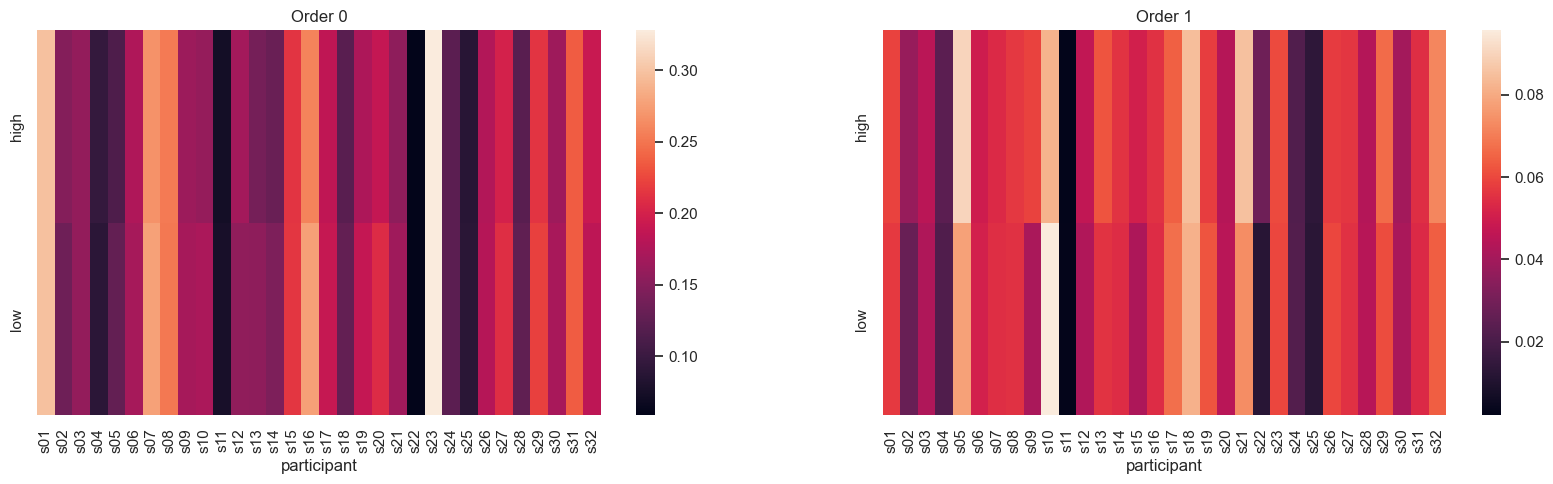

In [196]:
high_0 = mean_values_0.high
low_0 = mean_values_0.low

df_combined_0 = pd.concat([high_0, low_0], axis=1)

mean_values_1 = df.loc[df['order'] == 1].groupby(['valence_class', 'participant'])['bars'].mean()
high_1 = mean_values_1.high
low_1 = mean_values_1.low

df_combined_1 = pd.concat([high_1, low_1], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.heatmap(df_combined_0.T, yticklabels=['high', 'low'], ax=axs[0])
axs[0].set_title("Order 0")

sns.heatmap(df_combined_1.T, yticklabels=['high', 'low'], ax=axs[1])
axs[1].set_title("Order 1")
plt.show()

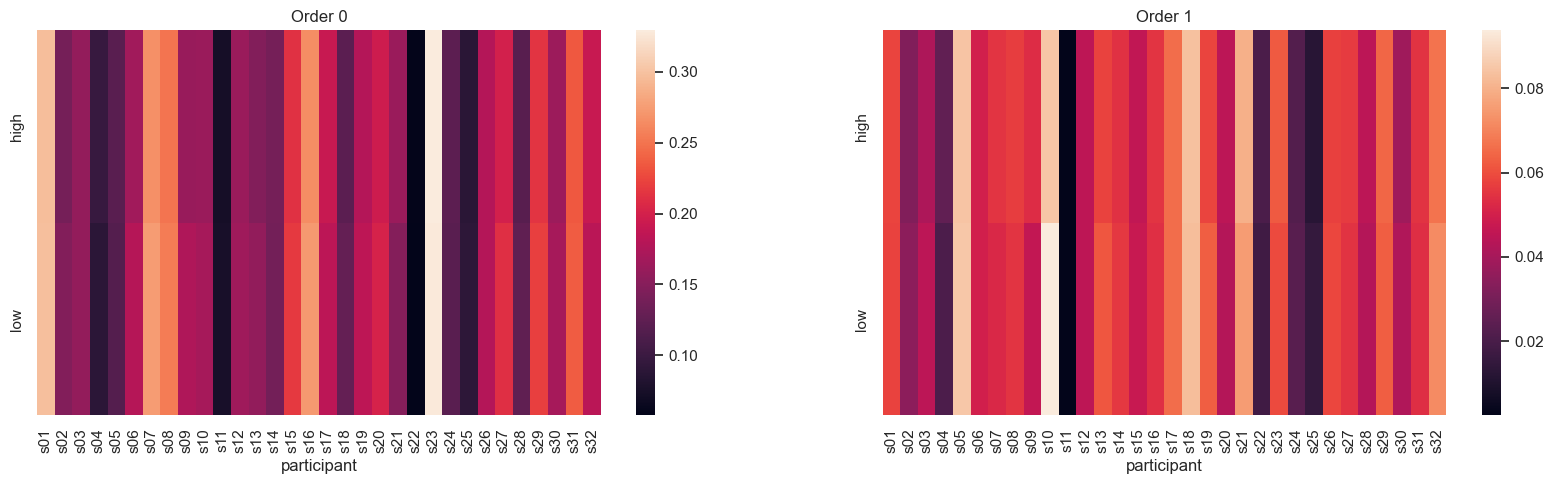

In [197]:
# check the distribution of mean bar length for low valence and high valence
# Create a new column to classify 'Y' values
threshold = 5
df['arousal_class'] = df['arousal'].apply(lambda y: 'high' if y > threshold else 'low')

mean_values_0 = df.loc[df['order'] == 0].groupby(['arousal_class', 'participant'])['bars'].mean()
high_0 = mean_values_0.high
low_0 = mean_values_0.low

df_combined_0 = pd.concat([high_0, low_0], axis=1)

mean_values_1 = df.loc[df['order'] == 1].groupby(['arousal_class', 'participant'])['bars'].mean()
high_1 = mean_values_1.high
low_1 = mean_values_1.low

df_combined_1 = pd.concat([high_1, low_1], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.heatmap(df_combined_0.T, yticklabels=['high', 'low'], ax=axs[0])
axs[0].set_title("Order 0")

sns.heatmap(df_combined_1.T, yticklabels=['high', 'low'], ax=axs[1])
axs[1].set_title("Order 1")
plt.show()